In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
train = pd.read_csv('/content/drive/My Drive/python/train.csv')
test = pd.read_csv('/content/drive/My Drive/python/test.csv')
bts= pd.read_csv('/content/drive/My Drive/python/bus_bts.csv')
location= pd.read_excel('/content/drive/My Drive/python/location.xlsx')
pop_j= pd.read_csv('/content/drive/My Drive/python/pop.csv', encoding = 'euc-kr' )
pop_s= pd.read_csv('/content/drive/My Drive/python/pop2.csv', encoding = 'euc-kr' )

In [ ]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [ ]:
train['date2'] = pd.to_datetime(train['date'])
train['weekday'] = train['date2'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])

In [ ]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [ ]:
del train['date2']
del test['date2']

In [ ]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [ ]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})

In [ ]:
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [ ]:
#승하차 시간대 통합 작업
train['68a']=train['6~7_ride']+train['7~8_ride'] #6~8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride'] #8~10시 승차인원
train['1012a']=train['10~11_ride']+train['11~12_ride'] #10~12시 승차인원

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] #6~8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff'] #8~10시 하차인원
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff'] #10~12시 하차인원

In [ ]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [ ]:
train2=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]
cor=train2.corr()

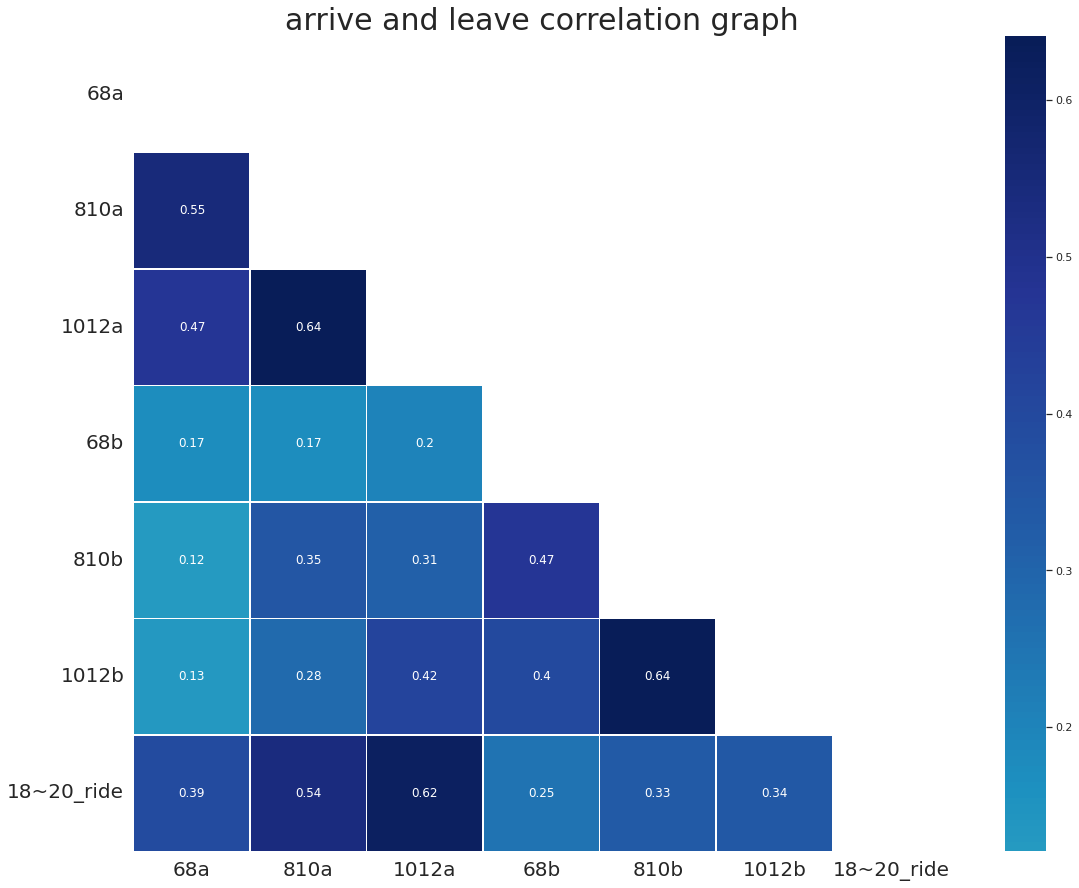

In [ ]:
sns.set(style="white")
mask=np.zeros_like(cor, dtype=np.bool) #상관계수에 대한 행렬 생성, 값은 True or False로
mask[np.triu_indices_from(mask)]= True #행렬에서 필요없는 부분(True값들) 제거

f,ax=plt.subplots(figsize=(20,15)) #f는 전체 사이즈이고 ax는 각 네모 사이즈
cmap=sns.diverging_palette(200, 59,as_cmap=True) #색 설정
sns.heatmap(cor,mask=mask,cmap='YlGnBu',center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생정
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

히트맵 확인 시 1820_ride와 상관관계가 높은 변수들은 810_ride, 1012_ride라는 사실을 알 수 있음



In [ ]:
jeju=(33.51411, 126.52969)
gosan=(33.29382, 126.16283)
seongsan=(33.38677, 126.8802)
po=(33.24616, 126.5653)

map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [ ]:
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")


for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc)

map_osm

In [ ]:
q1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
q2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
q3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
q4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=q1
train['dis_gosan']=q2
train['dis_seongsan']=q3
train['dis_po']=q4

In [ ]:
total=pd.DataFrame( list(zip( q1,q2,q3,q4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 1: 659, 2: 597, 3: 828})

In [ ]:
q1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
q2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
q3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
q4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=q1
test['dis_gosan']=q2
test['dis_seongsan']=q3
test['dis_po']=q4

total=pd.DataFrame( list(zip( q1,q2,q3,q4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [ ]:
raining=pd.read_csv('/content/drive/My Drive/python/weather.csv',engine='python')

In [ ]:
raining['location'] = [ str(i) for i in raining['location']]
raining['location'] = ['0' if i=='184' else i for i in raining['location'] ]
raining['location'] = ['1' if i=='185' else i for i in raining['location'] ]
raining['location'] = ['2' if i=='188' else i for i in raining['location'] ]
raining['location'] = ['3' if i=='189' else i for i in raining['location'] ]

raining.head()


,location,������,datetime,Thermo(C),precipitation(mm),wind(m/s),ǳ��(16����)
0,0,����,2019-09-01 1:00,23.7,NaN,2.1,180.0
1,0,����,2019-09-01 2:00,23.5,NaN,1.4,180.0
2,0,����,2019-09-01 3:00,23.4,NaN,1.1,180.0
3,0,����,2019-09-01 4:00,23.4,NaN,1.6,180.0
4,0,����,2019-09-01 5:00,23.3,NaN,1.2,180.0


In [ ]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['datetime']]

In [ ]:
raining['datetime'] = [ i.split(' ')[0] for i in raining['datetime'] ]

In [ ]:
rain2 = raining[ (raining['time']>12)  ]

In [ ]:
rain3 = rain2.groupby(['location','datetime'])[['Thermo(C)','precipitation(mm)','wind(m/s)']].mean()


In [ ]:
rain3.to_csv("rain3.csv")

In [ ]:
rain3=pd.read_csv("rain3.csv")

In [ ]:
rain3 = rain3.rename(columns={"datetime":"date","location":"dist_name"})
rain3= rain3.fillna(0.00000)

In [ ]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [ ]:
test2= test2.fillna(0.00000)

In [ ]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

In [ ]:
train2.shape, test2.shape, train.shape, test.shape

((415423, 45), (228170, 44), (415423, 39), (228170, 38))

In [ ]:
sort_810a = train2.sort_values('810a', ascending=False)
sort_810a.head(20)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,Thermo(C),precipitation(mm),wind(m/s),dist_name_0,dist_name_1,dist_name_2,dist_name_3
250003,250003,2019-09-19,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,0.0,40.0,131.0,50.0,50.0,97.0,0.0,9.0,47.0,18.0,27.0,81.0,131.0,0,0,0,1,0,0,0,40.0,181.0,147.0,9.0,65.0,108.0,6.144339,35.890210,38.390957,26.688214,23.709091,0.000000,3.327273,1,0,0,0
46016,46016,2019-09-04,23570000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,0.0,17.0,136.0,8.0,13.0,41.0,0.0,2.0,42.0,0.0,1.0,21.0,57.0,0,0,1,0,0,0,0,17.0,144.0,54.0,2.0,42.0,22.0,6.144339,35.890210,38.390957,26.688214,25.145455,1.675000,1.372727,1,0,0,0
199779,199779,2019-09-16,22530000,0,6103005,서귀포시구시외버스터미널,33.25217,126.56052,14.0,67.0,65.0,55.0,29.0,21.0,1.0,4.0,3.0,0.0,1.0,2.0,65.0,1,0,0,0,0,0,0,81.0,120.0,50.0,5.0,3.0,3.0,29.193388,37.337364,33.300639,0.801703,25.472727,0.000000,2.200000,0,0,0,1
328253,328253,2019-09-25,22530000,0,6103005,서귀포시구시외버스터미널,33.25217,126.56052,11.0,49.0,63.0,55.0,25.0,32.0,1.0,5.0,6.0,1.0,2.0,2.0,58.0,0,0,1,0,0,0,0,60.0,118.0,57.0,6.0,7.0,4.0,29.193388,37.337364,33.300639,0.801703,22.636364,0.000000,2.227273,0,0,0,1
82731,82731,2019-09-06,29210000,0,1564,제주시외버스터미널,33.49946,126.51479,13.0,18.0,48.0,66.0,35.0,18.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0,0,0,0,1,0,0,31.0,114.0,53.0,0.0,1.0,0.0,2.134693,39.904297,36.202951,28.484278,26.400000,5.327273,5.436364,1,0,0,0
401140,401140,2019-09-30,22530000,0,6103005,서귀포시구시외버스터미널,33.25217,126.56052,11.0,65.0,57.0,54.0,33.0,45.0,0.0,2.0,4.0,0.0,3.0,2.0,48.0,1,0,0,0,0,0,0,76.0,111.0,78.0,2.0,4.0,5.0,29.193388,37.337364,33.300639,0.801703,24.818182,0.950000,0.863636,0,0,0,1
296610,296610,2019-09-23,22530000,0,6103005,서귀포시구시외버스터미널,33.25217,126.56052,13.0,53.0,66.0,44.0,32.0,34.0,0.0,1.0,6.0,4.0,1.0,3.0,42.0,1,0,0,0,0,0,0,66.0,110.0,66.0,1.0,10.0,4.0,29.193388,37.337364,33.300639,0.801703,21.981818,0.500000,1.436364,0,0,0,1
315088,315088,2019-09-24,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,2.0,0.0,45.0,65.0,1.0,33.0,2.0,1.0,4.0,65.0,6.0,11.0,181.0,0,1,0,0,0,0,0,2.0,110.0,34.0,3.0,69.0,17.0,6.144339,35.890210,38.390957,26.688214,21.645455,0.000000,1.927273,1,0,0,0
12889,12889,2019-09-02,22520000,0,1565,시외버스출발지(가상정류소),33.49946,126.51478,14.0,50.0,73.0,36.0,26.0,23.0,0.0,0.0,2.0,0.0,0.0,0.0,38.0,1,0,0,0,0,0,0,64.0,109.0,49.0,0.0,2.0,0.0,2.135295,39.903533,36.203823,28.484432,25.245455,0.000000,1.545455,1,0,0,0
60983,60983,2019-09-05,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,0.0,14.0,97.0,10.0,69.0,61.0,0.0,0.0,49.0,2.0,23.0,43.0,46.0,0,0,0,1,0,0,0,14.0,107.0,130.0,0.0,51.0,66.0,6.144339,35.890210,38.390957,26.688214,26.472727,0.766667,2.009091,1,0,0,0


In [ ]:
sort_1012a = train2.sort_values('1012a', ascending=False)
sort_1012a.head(20)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,Thermo(C),precipitation(mm),wind(m/s),dist_name_0,dist_name_1,dist_name_2,dist_name_3
403861,403861,2019-09-30,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,7.0,0.0,2.0,36.0,124.0,50.0,4.0,2.0,1.0,18.0,48.0,18.0,74.0,1,0,0,0,0,0,0,7.0,38.0,174.0,6.0,19.0,66.0,6.144339,35.890210,38.390957,26.688214,23.918182,4.520000,1.345455,1,0,0,0
250003,250003,2019-09-19,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,0.0,40.0,131.0,50.0,50.0,97.0,0.0,9.0,47.0,18.0,27.0,81.0,131.0,0,0,0,1,0,0,0,40.0,181.0,147.0,9.0,65.0,108.0,6.144339,35.890210,38.390957,26.688214,23.709091,0.000000,3.327273,1,0,0,0
346925,346925,2019-09-26,23620000,0,443,제주한라대학교,33.47833,126.47512,2.0,6.0,10.0,7.0,45.0,95.0,0.0,0.0,0.0,0.0,4.0,36.0,152.0,0,0,0,1,0,0,0,8.0,17.0,140.0,0.0,0.0,40.0,6.439247,35.539798,39.015000,27.083473,24.827273,0.000000,3.627273,1,0,0,0
60983,60983,2019-09-05,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,0.0,14.0,97.0,10.0,69.0,61.0,0.0,0.0,49.0,2.0,23.0,43.0,46.0,0,0,0,1,0,0,0,14.0,107.0,130.0,0.0,51.0,66.0,6.144339,35.890210,38.390957,26.688214,26.472727,0.766667,2.009091,1,0,0,0
129369,129369,2019-09-10,23620000,0,443,제주한라대학교,33.47833,126.47512,0.0,5.0,8.0,65.0,29.0,99.0,0.0,0.0,0.0,34.0,15.0,57.0,66.0,0,1,0,0,0,0,0,5.0,73.0,128.0,0.0,34.0,72.0,6.439247,35.539798,39.015000,27.083473,27.745455,0.000000,2.072727,1,0,0,0
234392,234392,2019-09-18,23620000,0,443,제주한라대학교,33.47833,126.47512,0.0,13.0,7.0,13.0,63.0,62.0,0.0,0.0,0.0,0.0,10.0,42.0,152.0,0,0,1,0,0,0,0,13.0,20.0,125.0,0.0,0.0,52.0,6.439247,35.539798,39.015000,27.083473,24.472727,0.000000,3.072727,1,0,0,0
113867,113867,2019-09-09,23620000,0,443,제주한라대학교,33.47833,126.47512,2.0,52.0,6.0,20.0,69.0,40.0,0.0,14.0,0.0,0.0,34.0,0.0,64.0,1,0,0,0,0,0,0,54.0,26.0,109.0,14.0,0.0,34.0,6.439247,35.539798,39.015000,27.083473,26.318182,0.700000,2.118182,1,0,0,0
331091,331091,2019-09-25,23610000,0,2971,제주한라대학교(종점),33.47779,126.47574,0.0,22.0,75.0,3.0,30.0,75.0,0.0,7.0,30.0,26.0,11.0,51.0,72.0,0,0,1,0,0,0,0,22.0,78.0,105.0,7.0,56.0,62.0,6.431330,35.552644,38.943878,27.008679,22.863636,0.000000,2.800000,1,0,0,0
218371,218371,2019-09-17,23620000,0,443,제주한라대학교,33.47833,126.47512,0.0,8.0,3.0,13.0,28.0,73.0,0.0,0.0,0.0,1.0,1.0,32.0,101.0,0,1,0,0,0,0,0,8.0,16.0,101.0,0.0,1.0,33.0,6.439247,35.539798,39.015000,27.083473,24.309091,0.000000,2.709091,1,0,0,0
15635,15635,2019-09-02,23580000,0,447,제주고등학교/중흥S클래스,33.47626,126.48141,0.0,22.0,0.0,61.0,98.0,3.0,0.0,9.0,5.0,27.0,40.0,2.0,73.0,1,0,0,0,0,0,0,22.0,61.0,101.0,9.0,32.0,42.0,6.144339,35.890210,38.390957,26.688214,25.245455,0.000000,1.545455,1,0,0,0


In [ ]:
#오전 8시~10시, 오전 10~12시에 사람들이 많이 승차하는 정류장들과 다른 정류장 사이의 거리

sclass= (33.47626, 126.48141)
seoquipo_terminal= (33.25217, 126.56052)
jeju_terminal= (33.49946, 126.51479)
hanra_univ= (33.47833, 126.47512)
bus_departure= (33.49946, 126.51478)
sinjeju_school= (33.48505, 126.49632)
lottery= (33.25297, 126.56135)
enterance= (33.48900, 126.59840)
city_hall= (33.49956, 126.52977)
t1 = [geopy.distance.vincenty((i,j), sclass).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t2 = [geopy.distance.vincenty((i,j), seoquipo_terminal).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t3 = [geopy.distance.vincenty((i,j), jeju_terminal).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t4 = [geopy.distance.vincenty((i,j), hanra_univ).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t5 = [geopy.distance.vincenty((i,j), bus_departure).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t6 = [geopy.distance.vincenty((i,j), sinjeju_school).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t7 = [geopy.distance.vincenty((i,j), lottery).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t8 = [geopy.distance.vincenty((i,j), enterance).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
t9 = [geopy.distance.vincenty((i,j), city_hall).km for i,j in list(zip(train2['latitude'],train2['longitude']))]
train2['dis_sclass']=t1
train2['seoquipo_terminal']=t2
train2['jeju_terminal']=t3
train2['hanra_univ']=t4
train2['bus_departure']=t5
train2['sinjeju_school']=t6
train2['lottery']=t7
train2['enterance']=t8
train2['city_hall']=t9

In [ ]:
t1 = [geopy.distance.vincenty((i,j), sclass).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t2 = [geopy.distance.vincenty((i,j), seoquipo_terminal).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t3 = [geopy.distance.vincenty((i,j), jeju_terminal).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t4 = [geopy.distance.vincenty((i,j), hanra_univ).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t5 = [geopy.distance.vincenty((i,j), bus_departure).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t6 = [geopy.distance.vincenty((i,j), sinjeju_school).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t7 = [geopy.distance.vincenty((i,j), lottery).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t8 = [geopy.distance.vincenty((i,j), enterance).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
t9 = [geopy.distance.vincenty((i,j), city_hall).km for i,j in list(zip(test2['latitude'],test2['longitude']))]
test2['dis_sclass']=t1
test2['seoquipo_terminal']=t2
test2['jeju_terminal']=t3
test2['hanra_univ']=t4
test2['bus_departure']=t5
test2['sinjeju_school']=t6
test2['lottery']=t7
test2['enterance']=t8
test2['city_hall']=t9

In [ ]:
#인원이 많을 것으로 예상되는 '호텔', '공항', '학교', '시청', '터미널', '환승' 단어가 들어가는 정류장

a = train2[train2['station_name'].str.contains('호텔')]
Hotel= list(a['station_name'].unique())
def hotel(x):
  if x in Hotel:
    return 1
  else:
    return 0
train2['hotel']=train2['station_name'].apply(hotel)

b = train2[train2['station_name'].str.contains('공항')]
Airport = list(b['station_name'].unique())
def airport(x):
  if x in Airport:
    return 1
  else:
    return 0
train2['airport']=train2['station_name'].apply(airport)

c = train2[train2['station_name'].str.contains('학교')]
School = list(c['station_name'].unique())
def school(x):
  if x in School:
    return 1
  else:
    return 0
train2['school']=train2['station_name'].apply(school)

d = train2[train2['station_name'].str.contains('시청')]
Cityhall = list(d['station_name'].unique())
def cityhall(x):
  if x in Cityhall:
    return 1
  else:
    return 0
train2['cityhall']=train2['station_name'].apply(cityhall)

e = train2[train2['station_name'].str.contains('터미널')]
Terminal = list(e['station_name'].unique())
def terminal(x):
  if x in Terminal:
    return 1
  else:
    return 0
train2['terminal']=train2['station_name'].apply(terminal)

f = train2[train2['station_name'].str.contains('환승')]
Transfer = list(f['station_name'].unique())
def transfer(x):
  if x in Transfer:
    return 1
  else:
    return 0
train2['transfer']=train2['station_name'].apply(transfer)

In [ ]:
a = test2[test2['station_name'].str.contains('호텔')]
Hotel= list(a['station_name'].unique())
def hotel(x):
  if x in Hotel:
    return 1
  else:
    return 0
test2['hotel']=test2['station_name'].apply(hotel)

b = test2[test2['station_name'].str.contains('공항')]
Airport = list(b['station_name'].unique())
def airport(x):
  if x in Airport:
    return 1
  else:
    return 0
test2['airport']=test2['station_name'].apply(airport)

c = test2[test2['station_name'].str.contains('학교')]
School = list(c['station_name'].unique())
def school(x):
  if x in School:
    return 1
  else:
    return 0
test2['school']=test2['station_name'].apply(school)

d = test2[test2['station_name'].str.contains('시청')]
Cityhall = list(d['station_name'].unique())
def cityhall(x):
  if x in Cityhall:
    return 1
  else:
    return 0
test2['cityhall']=test2['station_name'].apply(cityhall)

e = test2[test2['station_name'].str.contains('터미널')]
Terminal = list(e['station_name'].unique())
def terminal(x):
  if x in Terminal:
    return 1
  else:
    return 0
test2['terminal']=test2['station_name'].apply(terminal)

f = test2[test2['station_name'].str.contains('환승')]
Transfer = list(f['station_name'].unique())
def transfer(x):
  if x in Transfer:
    return 1
  else:
    return 0
test2['transfer']=test2['station_name'].apply(transfer)

In [ ]:
#요일 변수
train2['date'] = pd.to_datetime(train2['date'])
train2['weekday'] = train2['date'].dt.weekday

def week(x):
  if x==5:
    return 0
  elif x==6:
    return 0
  else:
    return 1

train2['week']=train2['weekday'].apply(week)

In [ ]:
test2['date'] = pd.to_datetime(test2['date'])
test2['weekday'] = test2['date'].dt.weekday
def week(x):
  if x==5:
    return 0
  elif x==6:
    return 0
  else:
    return 1

test2['week']=test2['weekday'].apply(week)

In [ ]:
#시내와 시외
train2['in_out'].value_counts()
train2['in_out'] = train2['in_out'].map({'시내':0,'시외':1})
test2['in_out'] = test2['in_out'].map({'시내':0,'시외':1})

In [ ]:
pop_j= pd.read_csv('/content/drive/My Drive/python/pop.csv', encoding = 'euc-kr' )
pop_s= pd.read_csv('/content/drive/My Drive/python/pop2.csv', encoding = 'euc-kr' )

In [ ]:
#인구 통계와 정류장 연관시키기
#데이터 다듬기
pop_j1= pop_j.drop(pop_j.columns[1], axis=1)
pop_j= pop_j1.drop(pop_j1.columns[2:], axis=1)
pop_j=pop_j.drop(pop_j.index[0], axis=0)
pop_s1= pop_s.drop(pop_s.columns[1], axis=1)
pop_s= pop_s1.drop(pop_s1.columns[2:], axis=1)
pop_s=pop_s.drop(pop_s.index[0], axis=0)

In [ ]:
pop_j_split = pop_j["행정구역"].str.split("(")
pop_j['0'] = pop_j_split.str.get(0)
pop_j_split2 = pop_j['0'].str.split(" ")
pop_j['a'] = pop_j_split2.str.get(0)
pop_j['b'] = pop_j_split2.str.get(1)
pop_j['읍면동'] = pop_j_split2.str.get(2)
pop_j= pop_j.sort_values('읍면동')

pop_s_split = pop_s["행정구역"].str.split("(")
pop_s['0'] = pop_s_split.str.get(0)
pop_s_split2 = pop_s['0'].str.split(" ")
pop_s['a'] = pop_s_split2.str.get(0)
pop_s['b'] = pop_s_split2.str.get(1)
pop_s['읍면동'] = pop_s_split2.str.get(2)
pop_s= pop_s.sort_values('읍면동')

In [ ]:
pop_j= pop_j.drop(['행정구역', '0', 'a', 'b'], axis=1)
pop_j.set_index('읍면동', inplace=True)
pop_s= pop_s.drop(['행정구역', '0', 'a', 'b'], axis=1)
pop_s.set_index('읍면동', inplace=True)

location_jeju= location[location['시도'].str.contains('제주')]
location_jeju= location_jeju.sort_values('읍면동')

location_jeju=location_jeju.drop(location_jeju.columns[:2], axis=1)
location_jeju=location_jeju.drop(location_jeju.columns[2], axis=1)
location_jeju=location_jeju.drop(location_jeju.columns[4], axis=1)
location_jeju.set_index('읍면동', inplace=True)

In [ ]:
loca1= location_jeju[location_jeju.index== '한경면']
locala1= loca1['위도'].mean()
localo1= loca1['경도'].mean()

loca2= location_jeju[location_jeju.index== '한림읍']
locala2= loca2['위도'].mean()
localo2= loca2['경도'].mean()

loca3= location_jeju[location_jeju.index== '애월읍']
locala3= loca3['위도'].mean()
localo3= loca3['경도'].mean()

loca4= location_jeju[location_jeju.index== '조천읍']
locala4= loca4['위도'].mean()
localo4= loca4['경도'].mean()

loca5= location_jeju[location_jeju.index== '구좌읍']
locala5= loca5['위도'].mean()
localo5= loca5['경도'].mean()

loca6= location_jeju[location_jeju.index== '대정읍']
locala6= loca6['위도'].mean()
localo6= loca6['경도'].mean()

loca7= location_jeju[location_jeju.index== '안덕면']
locala7= loca7['위도'].mean()
localo7= loca7['경도'].mean()

loca8= location_jeju[location_jeju.index== '남원읍']
locala8= loca8['위도'].mean()
localo8= loca8['경도'].mean()

loca9= location_jeju[location_jeju.index== '표선면']
locala9= loca9['위도'].mean()
localo9= loca9['경도'].mean()

loca10= location_jeju[location_jeju.index== '성산읍']
locala10= loca10['위도'].mean()
localo10= loca10['경도'].mean()

In [ ]:
location_center= location_jeju.drop(['한경면', '한림읍', '애월읍', '조천읍', '구좌읍', '대정읍', '안덕면', '남원읍', '표선면', '성산읍'])

locaj= location_center[location_center['시군구']=='제주시']
locas= location_center[location_center['시군구']=='서귀포시']
localaj= locaj['위도'].mean()
localoj= locaj['경도'].mean()
localas= locas['위도'].mean()
localos= locas['경도'].mean()

In [ ]:
loc_df = pd.DataFrame([['한경면', locala1, localo1],
                       ['한림음', locala2, localo2],
                       ['애월읍', locala3, localo3],
                       ['제주시', localaj, localoj],
                       ['조천읍', locala4, localo4],
                       ['구좌읍', locala5, localo5],
                       ['대정읍', locala6, localo6],
                       ['안덕면', locala7, localo7],
                       ['서귀포시', localas, localos],
                       ['남원읍', locala8, localo8],
                       ['표선면', locala9, localo9],
                       ['성산읍', locala10, localo10]], columns = ['행정구역', '위도', '경도'])
loc_df

,행정구역,위도,경도
0,한경면,33.331291,126.210643
1,한림음,33.393637,126.266561
2,애월읍,33.449823,126.368412
3,제주시,33.537811,126.517387
4,조천읍,33.506449,126.663823
5,구좌읍,33.521459,126.812629
6,대정읍,33.247369,126.250328
7,안덕면,33.277855,126.343928
8,서귀포시,33.259744,126.515409
9,남원읍,33.301127,126.691450


In [ ]:
pop_1= pop_j[pop_j.index== '한경면']
pop1= pop_1['2019년09월_거주자_연령구간인구수'].sum()

pop_2= pop_j[pop_j.index== '한림읍']
pop2= pop_2['2019년09월_거주자_연령구간인구수'].sum()

pop_3= pop_j[pop_j.index== '애월읍']
pop3= pop_3['2019년09월_거주자_연령구간인구수'].sum()

pop_4= pop_j[pop_j.index== '조천읍']
pop4= pop_4['2019년09월_거주자_연령구간인구수'].sum()

pop_5= pop_j[pop_j.index== '구좌읍']
pop5= pop_5['2019년09월_거주자_연령구간인구수'].sum()

pop_6= pop_s[pop_s.index== '대정읍']
pop6= pop_6['2019년09월_거주자_연령구간인구수'].sum()

pop_7= pop_s[pop_s.index== '안덕면']
pop7= pop_7['2019년09월_거주자_연령구간인구수'].sum()

pop_8= pop_s[pop_s.index== '남원읍']
pop8= pop_8['2019년09월_거주자_연령구간인구수'].sum()

pop_9= pop_s[pop_s.index== '표선면']
pop9= pop_9['2019년09월_거주자_연령구간인구수'].sum()

pop_10= pop_s[pop_s.index== '성산읍']
pop10= pop_10['2019년09월_거주자_연령구간인구수'].sum()

pop_jeju= pop_j.drop(['한경면', '한림읍', '애월읍', '조천읍', '구좌읍'])
popj= pop_jeju['2019년09월_거주자_연령구간인구수'].sum()
pop_po= pop_s.drop(['대정읍', '안덕면', '남원읍', '표선면', '성산읍'])
pops= pop_po['2019년09월_거주자_연령구간인구수'].sum()

In [ ]:
pop_df = pd.DataFrame([['한경면', pop1],
                       ['한림음', pop2],
                       ['애월읍', pop3],
                       ['제주시', popj],
                       ['조천읍', pop4],
                       ['구좌읍', pop5],
                       ['대정읍', pop6],
                       ['안덕면', pop7],
                       ['서귀포시', pops],
                       ['남원읍', pop8],
                       ['표선면', pop9],
                       ['성산읍', pop10]], columns = ['행정구역', '인구수'])
pop_df

,행정구역,인구수
0,한경면,5745
1,한림음,14375
2,애월읍,24717
3,제주시,274375
4,조천읍,16813
5,구좌읍,10176
6,대정읍,13983
7,안덕면,8213
8,서귀포시,69944
9,남원읍,12614


In [ ]:
merge_df = pd.merge(loc_df, pop_df)
merge_df

,행정구역,위도,경도,인구수
0,한경면,33.331291,126.210643,5745
1,한림음,33.393637,126.266561,14375
2,애월읍,33.449823,126.368412,24717
3,제주시,33.537811,126.517387,274375
4,조천읍,33.506449,126.663823,16813
5,구좌읍,33.521459,126.812629,10176
6,대정읍,33.247369,126.250328,13983
7,안덕면,33.277855,126.343928,8213
8,서귀포시,33.259744,126.515409,69944
9,남원읍,33.301127,126.691450,12614


In [ ]:
#정류장의 위치에 따른 인구 수
coord0= (merge_df.iloc[0, 1], merge_df.iloc[0, 2])
coord1= (merge_df.iloc[1, 1], merge_df.iloc[1, 2])
coord2= (merge_df.iloc[2, 1], merge_df.iloc[2, 2])
coord3= (merge_df.iloc[3, 1], merge_df.iloc[3, 2])
coord4= (merge_df.iloc[4, 1], merge_df.iloc[4, 2])
coord5= (merge_df.iloc[5, 1], merge_df.iloc[5, 2])
coord6= (merge_df.iloc[6, 1], merge_df.iloc[6, 2])
coord7= (merge_df.iloc[7, 1], merge_df.iloc[7, 2])
coord8= (merge_df.iloc[8, 1], merge_df.iloc[8, 2])
coord9= (merge_df.iloc[9, 1], merge_df.iloc[9, 2])
coord10= (merge_df.iloc[10, 1], merge_df.iloc[10, 2])
coord11= (merge_df.iloc[11, 1], merge_df.iloc[11, 2])

In [ ]:
c0 = [geopy.distance.vincenty( (i,j), coord0).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c1 = [geopy.distance.vincenty( (i,j), coord1).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c2 = [geopy.distance.vincenty( (i,j), coord2).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c3 = [geopy.distance.vincenty( (i,j), coord3).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c4 = [geopy.distance.vincenty( (i,j), coord4).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c5 = [geopy.distance.vincenty( (i,j), coord5).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c6 = [geopy.distance.vincenty( (i,j), coord6).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c7 = [geopy.distance.vincenty( (i,j), coord7).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c8 = [geopy.distance.vincenty( (i,j), coord8).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c9 = [geopy.distance.vincenty( (i,j), coord9).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c10 = [geopy.distance.vincenty( (i,j), coord10).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]
c11 = [geopy.distance.vincenty( (i,j), coord11).km for i,j in list( zip( train2['latitude'],train2['longitude'] )) ]

In [ ]:
train2['coord0']=c0
train2['coord1']=c1
train2['coord2']=c2
train2['coord3']=c3
train2['coord4']=c4
train2['coord5']=c5
train2['coord6']=c6
train2['coord7']=c7
train2['coord8']=c8
train2['coord9']=c8
train2['coord10']=c10
train2['coord11']=c11

In [ ]:
total_coords=pd.DataFrame(list(zip(c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11)),columns=['coord0', 'coord1', 'coord2', 'coord3', 'coord4', 'coord5', 'coord6', 'coord7','coord8', 'coord9', 'coord10', 'coord11'] )
train2['dist_coords'] = total_coords.apply(lambda x: x.argmin(), axis=1)

coord_data=train2[['station_name','latitude','longitude','dist_coords']]

In [ ]:
pop_list={0: 5745, 1: 14375, 2: 24717, 3: 274375, 4: 16813, 5: 10176,
          6: 13983, 7: 8213, 8: 69944, 9: 12614, 10: 8356, 11: 10464}

train2=train2.replace({'dist_coords': pop_list})

In [ ]:
c0 = [geopy.distance.vincenty( (i,j), coord0).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c1 = [geopy.distance.vincenty( (i,j), coord1).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c2 = [geopy.distance.vincenty( (i,j), coord2).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c3 = [geopy.distance.vincenty( (i,j), coord3).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c4 = [geopy.distance.vincenty( (i,j), coord4).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c5 = [geopy.distance.vincenty( (i,j), coord5).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c6 = [geopy.distance.vincenty( (i,j), coord6).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c7 = [geopy.distance.vincenty( (i,j), coord7).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c8 = [geopy.distance.vincenty( (i,j), coord8).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c9 = [geopy.distance.vincenty( (i,j), coord9).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c10 = [geopy.distance.vincenty( (i,j), coord10).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]
c11 = [geopy.distance.vincenty( (i,j), coord11).km for i,j in list( zip( test2['latitude'],test2['longitude'] )) ]

test2['coord0']=c0
test2['coord1']=c1
test2['coord2']=c2
test2['coord3']=c3
test2['coord4']=c4
test2['coord5']=c5
test2['coord6']=c6
test2['coord7']=c7
test2['coord8']=c8
test2['coord9']=c8
test2['coord10']=c10
test2['coord11']=c11

total_coords=pd.DataFrame(list(zip(c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11)),columns=['coord0', 'coord1', 'coord2', 'coord3', 'coord4', 'coord5', 'coord6', 'coord7','coord8', 'coord9', 'coord10', 'coord11'] )
test2['dist_coords'] = total_coords.apply(lambda x: x.argmin(), axis=1)

coord_data=test2[['station_name','latitude','longitude','dist_coords']]

test2=test2.replace({'dist_coords': pop_list})

In [ ]:
train2= train2.astype({"dist_coords": "int32"})
test2= test2.astype({"dist_coords": "int32"})

In [ ]:
print(train2)

            id       date  bus_route_id  ...    coord10    coord11 dist_coords
0            0 2019-09-01       4270000  ...  32.187384  37.032441      274375
1            1 2019-09-01       4270000  ...  32.867170  37.805381      274375
2            2 2019-09-01       4270000  ...  33.432746  38.684969      274375
3            3 2019-09-01       4270000  ...  33.177232  37.572762      274375
4            4 2019-09-01       4270000  ...  37.105521  47.111013        8213
...        ...        ...           ...  ...        ...        ...         ...
415418  415418 2019-09-30      32820000  ...  50.067999  57.526892       14375
415419  415419 2019-09-30      32820000  ...  31.053321  35.391935      274375
415420  415420 2019-09-30      32820000  ...  51.301578  61.144430       13983
415421  415421 2019-09-30      32820000  ...  46.215866  52.657448       24717
415422  415422 2019-09-30      32820000  ...  28.959587  39.379463       69944

[415423 rows x 75 columns]


In [ ]:
train2.isnull().sum()

id                   0
date                 0
bus_route_id         0
in_out          415423
station_code         0
                 ...  
coord8               0
coord9               0
coord10              0
coord11              0
dist_coords          0
Length: 75, dtype: int64

In [ ]:
train2= train2.fillna(0.00000)

In [ ]:
train2.isnull().sum()

id              0
date            0
bus_route_id    0
in_out          0
station_code    0
               ..
coord8          0
coord9          0
coord10         0
coord11         0
dist_coords     0
Length: 75, dtype: int64

In [ ]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','Thermo(C)', 'precipitation(mm)', 'wind(m/s)',
           'dist_name_1','dist_name_0','dist_name_3', 'dist_name_2','dis_sclass', 'seoquipo_terminal', 'jeju_terminal', 'hanra_univ', 'bus_departure', 'sinjeju_school', 'lottery',	'enterance',	'city_hall',
           'hotel', 'airport',	'school',	'cityhall',	'terminal',	'transfer',	'week', 'coord0', 'coord1', 'coord2', 'coord3', 'coord4', 'coord5',
           'coord6', 'coord7','coord8', 'coord9', 'coord10', 'coord11', 'dist_coords']

target=['18~20_ride']

In [ ]:
X_train=train2[input_var]
random.seed(1217)
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

X_train.shape, y_train.shape

((4154, 56), (4154, 1))

In [ ]:
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}

rf = RandomForestRegressor(random_state=1217)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

((415423, 56), (415423, 1), (228170, 56))

In [ ]:
X_test = X_test.astype(float)

In [ ]:
X_test= X_test.fillna(0.00000)

In [ ]:
X_test.isnull().sum()

in_out               0
latitude             0
longitude            0
68a                  0
810a                 0
1012a                0
68b                  0
810b                 0
1012b                0
weekday_0            0
weekday_1            0
weekday_2            0
weekday_3            0
weekday_4            0
weekday_5            0
weekday_6            0
dis_jeju             0
dis_gosan            0
dis_seongsan         0
dis_po               0
Thermo(C)            0
precipitation(mm)    0
wind(m/s)            0
dist_name_1          0
dist_name_0          0
dist_name_3          0
dist_name_2          0
dis_sclass           0
seoquipo_terminal    0
jeju_terminal        0
hanra_univ           0
bus_departure        0
sinjeju_school       0
lottery              0
enterance            0
city_hall            0
hotel                0
airport              0
school               0
cityhall             0
terminal             0
transfer             0
week                 0
coord0     

In [ ]:
rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=2,n_estimators=100,random_state=1217)

rf.fit(X_train,y_train)

test['18~20_ride'] = rf.predict(X_test)
test[['id','18~20_ride']].to_csv("submission_fi_2.csv",index=False)

In [ ]:
test[['id','18~20_ride']].to_csv("/content/drive/My Drive/python/submission_fi.csv",index=False)

test[['id','18~20_ride']].to_csv("submission.csv",index=False)